In [1]:
import numpy as np
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
# Download mnist dataset with train, validation and test seperation using download.py 
# from https://github.com/CW-Huang/IFT6135H19_assignment/blob/master/download.py 
# Make sure the downloaded dataset is with the same directory with this code 
# Load it as numpy array

dataset = np.load('mnist.pkl.npy')

In [4]:
# Build train, validation and test arrays
im_size = (28,28)
train_x = np.reshape(dataset[0,0], [-1,1,im_size[0],im_size[1]])
train_y = dataset[0,1]

validate_x = np.reshape(dataset[1,0], [-1,1,im_size[0],im_size[1]])
validate_y = dataset[1,1]

test_x = np.reshape(dataset[2,0], [-1,1,im_size[0],im_size[1]])
test_y = dataset[2,1]

# Pytorch train and test sets
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

validate_x = torch.from_numpy(validate_x)
validate_y = torch.from_numpy(validate_y)

test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

In [5]:
# Convert to tensor
train_dataset = torch.utils.data.TensorDataset(train_x.float(),train_y.float())
val_dataset = torch.utils.data.TensorDataset(validate_x.float(),validate_y.float())
test_dataset = torch.utils.data.TensorDataset(test_x.float(),test_y.float())

In [6]:
# Apply torch data loader
train_batch_size = 50;
val_batch_size = 1000;
test_batch_size = 1000;

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = val_batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle = False)

In [7]:
# Define numbers of epoch and learning rate
num_epochs = 10;
learning_rate = 0.01;

In [8]:
# Define a CNN model with five convolutional layers and one linear layer. This architecture refers to the architecture from  
# https://github.com/MaximumEntropy/welcome_tutorials/blob/pytorch/pytorch/4.Image Classification with Convnets and ResNets.ipynb
# The total numbers of parameters are 
# (3*3*1+1)*16 + (3*3*16+1)*32 + (3*3*32+1)*64 + (3*3*64+1)*128 + (3*3*128+1)*256  + (256+1)*10 = 394890

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=1),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 5           
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        
        # Logistic Regression
        self.clf = nn.Linear(256, 10)

    def forward(self, x):   
        return self.clf(self.conv(x).squeeze())

In [9]:
# Check if GPU is available
cuda_available = torch.cuda.is_available()

In [10]:
# Generate a instance of the CNN
cnn = CNN();
if cuda_available:
    cnn = cnn.cuda()
    
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate, momentum=0.5);

In [11]:
print(cnn)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Linear(in_features=256, out_features=10, bias=True)
)

In [12]:
# Do train and validation test
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    
# Train model
    train_losses = []
    val_losses = []

    for i, (images, labels) in enumerate(train_loader):
        
        if cuda_available:
            images, labels = images.cuda(), labels.cuda()
        
        labels = labels.long()
        images = Variable(images)
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        

        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item());

    train_loss_list.append(np.mean(train_losses))
    print('Epoch : %d Train loss : %.3f ' % (epoch+1, np.mean(train_losses)))
    
            
# Validation test
    cnn.eval()
    correct = 0
    total = 0

    for (images, labels) in val_loader:
        images, labels = Variable(images), Variable(labels)
        labels = labels.long()
        
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        val_losses.append(loss.item());
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
 
        correct += (predicted == labels.data).sum()
    
    val_loss_list.append(np.mean(val_losses))
    print('Epoch : %d Validation loss : %.3f ' % (epoch+1, np.mean(val_losses)))
    print('Test Accuracy of the model on the 10000 validation images: %.4f %%' % (100 * correct / total))
      

Epoch : 1 Train loss : 2.090 
Epoch : 1 Validation loss : 0.557 
Test Accuracy of the model on the 10000 validation images: 83.0000 %
Epoch : 2 Train loss : 0.269 
Epoch : 2 Validation loss : 0.117 
Test Accuracy of the model on the 10000 validation images: 96.0000 %
Epoch : 3 Train loss : 0.117 
Epoch : 3 Validation loss : 0.098 
Test Accuracy of the model on the 10000 validation images: 96.0000 %
Epoch : 4 Train loss : 0.082 
Epoch : 4 Validation loss : 0.068 
Test Accuracy of the model on the 10000 validation images: 97.0000 %
Epoch : 5 Train loss : 0.067 
Epoch : 5 Validation loss : 0.060 
Test Accuracy of the model on the 10000 validation images: 98.0000 %
Epoch : 6 Train loss : 0.055 
Epoch : 6 Validation loss : 0.078 
Test Accuracy of the model on the 10000 validation images: 97.0000 %
Epoch : 7 Train loss : 0.047 
Epoch : 7 Validation loss : 0.055 
Test Accuracy of the model on the 10000 validation images: 98.0000 %
Epoch : 8 Train loss : 0.041 
Epoch : 8 Validation loss : 0.05

In [13]:
# Show train and validation errors
print('The train erros of 10 epochs are', train_loss_list)
print('========================================================================================================================')
print('The validation erros of 10 epochs are', val_loss_list)

The train erros of 10 epochs are [2.0898662351071833, 0.26863609709590675, 0.11656876287609338, 0.082333156525855877, 0.066571214697556572, 0.055100712203187865, 0.047392328367102894, 0.040538050214119721, 0.035341240907262546, 0.032806129832955777]
The validation erros of 10 epochs are [0.5572406023740768, 0.11719357892870903, 0.098012304306030279, 0.067866875417530531, 0.060328469984233378, 0.078000639937818056, 0.055262971483170983, 0.054385329596698284, 0.050006810948252677, 0.041478047519922255]


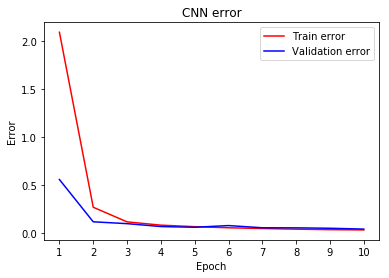

In [14]:
# Plot train and validation error of each epoch
x_axis = np.linspace(1, num_epochs, num_epochs)
plt.gca().set_prop_cycle(color=['red', 'blue'])
plt.plot(x_axis, train_loss_list)
plt.plot(x_axis, val_loss_list)
#plt.axis(x_axis)
plt.xticks(x_axis)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('CNN error')
plt.legend(['Train error', 'Validation error'], loc='upper right')
plt.show()

In [15]:
# Test the model with test dataset
cnn.eval()

success = 0 # Number of correct prediction
total = 0 # Total number of test dataset

for (images, labels) in test_loader:
    
    images, labels = Variable(images), Variable(labels)
    labels = labels.long()
        
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
 
    # Add correct prediciton to success
    success += (predicted == labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * success / total))

Test Accuracy of the model on the 10000 test images: 99.0000 %
